In [ ]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

import string
characters = "0123456789abcdefghijklmnpqrstuvwxyz"
width, height, n_len, n_class = 96, 72, 4, len(characters)

In [ ]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=4, width=128, height=64): # w=96, h=72
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

Text(0.5, 1.0, 'f2k5')

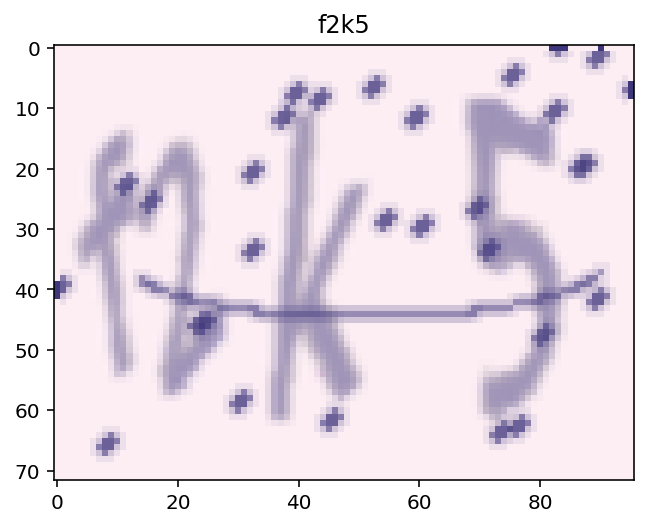

In [ ]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

data = CaptchaSequence(characters, batch_size=1, steps=1, n_len=n_len, width=width, height=height)
X, y = data[0]
plt.imshow(X[0])
plt.title(decode(y))

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128, steps=1000, n_len=n_len, width=width, height=height)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100, n_len=n_len, width=width, height=height)
basename = "cnn_" + str(width) + "x" + str(height) + "_" + str(n_len)
callbacks = [EarlyStopping(patience=3), CSVLogger(basename+'_best.csv'), ModelCheckpoint(basename+'_best.h5', save_best_only=True)]


model.compile(loss='categorical_crossentropy',
                optimizer=Adam(1e-3, amsgrad=True), 
                metrics=['accuracy'])


model.fit(train_data, epochs=15, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Epoch 1/15
1000/1000 [==============================] - 496s 481ms/step - loss: 4.3031 - c1_loss: 1.0156 - c2_loss: 1.1481 - c3_loss: 1.1398 - c4_loss: 0.9996 - c1_accuracy: 0.7242 - c2_accuracy: 0.6864 - c3_accuracy: 0.6890 - c4_accuracy: 0.7284 - val_loss: 17.9455 - val_c1_loss: 4.8453 - val_c2_loss: 4.2260 - val_c3_loss: 4.5375 - val_c4_loss: 4.3367 - val_c1_accuracy: 0.3288 - val_c2_accuracy: 0.3866 - val_c3_accuracy: 0.3622 - val_c4_accuracy: 0.3398
Epoch 2/15
1000/1000 [==============================] - 482s 481ms/step - loss: 0.0985 - c1_loss: 0.0147 - c2_loss: 0.0355 - c3_loss: 0.0340 - c4_loss: 0.0143 - c1_accuracy: 0.9966 - c2_accuracy: 0.9901 - c3_accuracy: 0.9903 - c4_accuracy: 0.9965 - val_loss: 10.5874 - val_c1_loss: 1.6380 - val_c2_loss: 2.6522 - val_c3_loss: 3.4378 - val_c4_loss: 2.8594 - val_c1_accuracy: 0.6302 - val_c2_accuracy: 0.5113 - val_c3_accuracy: 0.4320 - val_c4_accuracy: 0.4435
Epoch 3/15
1000/1000 [==============================] - 481s 479ms/step - loss: 0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_weights(basename + '_best.h5')

callbacks = [EarlyStopping(patience=3), CSVLogger(basename + '_best_best.csv', append=True), 
                ModelCheckpoint(basename + '_best_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
                optimizer=Adam(1e-4, amsgrad=True), 
                metrics=['accuracy'])
model.fit_generator(train_data, epochs=5, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

<ipython-input-9-70d9171c01dd>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data, epochs=5, validation_data=valid_data, workers=4, use_multiprocessing=True,


Epoch 1/5
1000/1000 [==============================] - 482s 478ms/step - loss: 0.0115 - c1_loss: 0.0016 - c2_loss: 0.0041 - c3_loss: 0.0040 - c4_loss: 0.0019 - c1_accuracy: 0.9996 - c2_accuracy: 0.9988 - c3_accuracy: 0.9988 - c4_accuracy: 0.9995 - val_loss: 0.0109 - val_c1_loss: 0.0022 - val_c2_loss: 0.0046 - val_c3_loss: 0.0030 - val_c4_loss: 0.0011 - val_c1_accuracy: 0.9994 - val_c2_accuracy: 0.9984 - val_c3_accuracy: 0.9991 - val_c4_accuracy: 0.9997
Epoch 2/5
1000/1000 [==============================] - 478s 477ms/step - loss: 0.0107 - c1_loss: 0.0016 - c2_loss: 0.0042 - c3_loss: 0.0037 - c4_loss: 0.0013 - c1_accuracy: 0.9996 - c2_accuracy: 0.9988 - c3_accuracy: 0.9990 - c4_accuracy: 0.9996 - val_loss: 0.0124 - val_c1_loss: 8.1444e-04 - val_c2_loss: 0.0041 - val_c3_loss: 0.0057 - val_c4_loss: 0.0019 - val_c1_accuracy: 0.9998 - val_c2_accuracy: 0.9987 - val_c3_accuracy: 0.9984 - val_c4_accuracy: 0.9995
Epoch 3/5
1000/1000 [==============================] - 483s 481ms/step - loss: 0.0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>